In [1]:

#https://www.kaggle.com/code/vikashrajluhaniwal/matrix-factorization-recommendation-using-pyspark/notebook

#https://www.kaggle.com/code/vikashrajluhaniwal/matrix-factorization-recommendation-using-pyspark/data

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn

from pyspark import SparkContext, SQLContext   # required for dealing with dataframes
from pyspark.sql.functions import isnan, count, col
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.recommendation import ALS      # for Matrix Factorization using ALS 

In [2]:
#!pip install pyspark

In [3]:
sc = SparkContext()      # instantiating spark context 
sqlContext = SQLContext(sc) # instantiating SQL context 

/Users/lana-n/opt/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
jester_ratings_df = sqlContext.read.csv("/Users/lana-n/datacsv/jester_ratings.csv",header = True, inferSchema = True)
jester_items_df = sqlContext.read.csv("/Users/lana-n/datacsv/jester_items.csv",header = True, inferSchema = True)

In [5]:
print("Ratings dataset shape:", (jester_ratings_df.count(), len(jester_ratings_df.columns)))


Ratings dataset shape: (1761439, 3)


In [6]:

jester_ratings_df.show(5)

+------+------+-------------------+
|userId|jokeId|             rating|
+------+------+-------------------+
|     1|     5|0.21899999999999997|
|     1|     7|             -9.281|
|     1|     8|             -9.281|
|     1|    13| -6.781000000000001|
|     1|    15|              0.875|
+------+------+-------------------+
only showing top 5 rows



In [7]:
df1 = pd.read_csv("/Users/lana-n/datacsv/jester_ratings.csv")
df2 = pd.read_csv("/Users/lana-n/datacsv/jester_items.csv")

In [8]:
df1

,userId,jokeId,rating
0,1,5,0.219
1,1,7,-9.281
2,1,8,-9.281
3,1,13,-6.781
4,1,15,0.875
...,...,...,...
1761434,63978,57,-8.531
1761435,63978,24,-9.062
1761436,63978,124,-9.031
1761437,63978,58,-8.656


In [9]:
df2

,jokeId,jokeText
0,1,"A man visits the doctor. The doctor says ""I ha..."
1,2,This couple had an excellent relationship goin...
2,3,Q. What's 200 feet long and has 4 teeth? \n\nA...
3,4,Q. What's the difference between a man and a t...
4,5,Q.\tWhat's O. J. Simpson's Internet address? \...
...,...,...
145,146,America: 8:00 - Welcome to work! 12:00 - Lunch...
146,147,It was the day of the big sale. Rumors of the ...
147,148,"Recently a teacher, a garbage collector, and a..."
148,149,"A little girl asked her father, ""Daddy? Do all..."


In [10]:
df1.shape

(1761439, 3)

In [11]:
df2.shape

(150, 2)

In [12]:
df2["jokeId"].nunique()

150

In [13]:
df1.dtypes

userId      int64
jokeId      int64
rating    float64
dtype: object

In [14]:
set(df2["jokeId"].unique().tolist()) - set(df1["jokeId"].unique().tolist())

{1, 2, 3, 4, 6, 9, 10, 11, 12, 14}

In [15]:
df1[df1["jokeId"].isin([1, 2, 3, 4, 6, 9, 10, 11, 12, 14])]

,userId,jokeId,rating


In [16]:
df1.isnull().sum()

userId    0
jokeId    0
rating    0
dtype: int64

In [17]:
df2.isnull().sum()

jokeId      0
jokeText    0
dtype: int64

In [18]:
df1["rating"].max()

10.0

In [19]:
jester_ratings_df.show(5)

+------+------+-------------------+
|userId|jokeId|             rating|
+------+------+-------------------+
|     1|     5|0.21899999999999997|
|     1|     7|             -9.281|
|     1|     8|             -9.281|
|     1|    13| -6.781000000000001|
|     1|    15|              0.875|
+------+------+-------------------+
only showing top 5 rows



In [20]:
print("Number of unique users: ", jester_ratings_df.select("userId").distinct().count())
print("Number of unique jokes: ", jester_ratings_df.select("jokeId").distinct().count())
print("Total number of ratings: ", jester_ratings_df.count())

Number of unique users:  59132
Number of unique jokes:  140
Total number of ratings:  1761439


/Users/lana-n/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Total number of ratings')

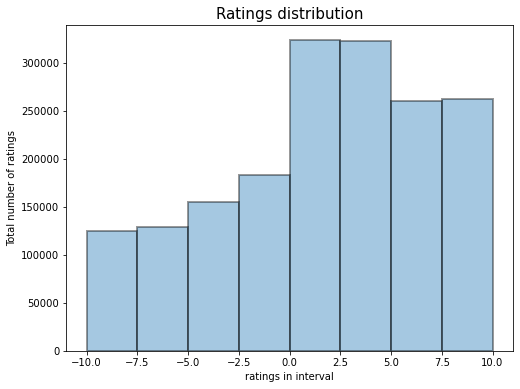

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('Ratings distribution', fontsize=15)
sns.distplot(jester_ratings_df.toPandas()['rating'], kde=False, bins = 8,hist_kws=dict(edgecolor="k", linewidth=2))
ax.set_xlabel("ratings in interval")
ax.set_ylabel("Total number of ratings")

In [22]:
ratings_per_user = jester_ratings_df.groupby('userId').agg({"rating":"count"})
ratings_per_user.describe().show()

+-------+------------------+------------------+
|summary|            userId|     count(rating)|
+-------+------------------+------------------+
|  count|             59132|             59132|
|   mean|31967.599996617737|29.788253399174728|
| stddev|18330.168879129356| 32.80176140980319|
|    min|                 1|                 1|
|    max|             63978|               140|
+-------+------------------+------------------+



In [23]:
ratings_per_joke = jester_ratings_df.groupby('jokeId').agg({"rating":"count"})
ratings_per_joke.describe().show()

+-------+------------------+------------------+
|summary|            jokeId|     count(rating)|
+-------+------------------+------------------+
|  count|               140|               140|
|   mean| 80.37857142857143|12581.707142857143|
| stddev|40.771951823508005|11866.405872802346|
|    min|                 5|               166|
|    max|               150|             59122|
+-------+------------------+------------------+



In [24]:
X_train, X_test = jester_ratings_df.randomSplit([0.9,0.1])   # 90:10 ratio
print("Training data size : ", X_train.count())
print("Test data size : ", X_test.count())
print("Number of unique users in Training set", X_train[["userId"]].distinct().count())
print("Number of unique users in Test set", X_test[["userId"]].distinct().count())

Training data size :  1584472
Test data size :  176967
Number of unique users in Training set 58976
Number of unique users in Test set 44897


In [25]:
als = ALS(userCol="userId",itemCol="jokeId",ratingCol="rating",rank=5, maxIter=10, seed=0)
model = als.fit(X_train)

In [26]:
# displaying the latent features for five users
model.userFactors.show(5, truncate = False)  

+---+---------------------------------------------------------------+
|id |features                                                       |
+---+---------------------------------------------------------------+
|10 |[-1.3194503, -0.036954522, 1.0630358, -0.47795826, -0.5625431] |
|40 |[0.10418015, -1.9727509, 0.40754092, 2.0121865, -2.047171]     |
|50 |[-1.9358298, -0.28178775, -0.63467675, -0.77738357, -1.6449097]|
|60 |[1.5819291, 1.0254087, 0.18734501, 2.9856377, 3.8196201]       |
|80 |[-3.1529217, -0.9871033, 0.99292904, -1.3100173, 1.1474644]    |
+---+---------------------------------------------------------------+
only showing top 5 rows



In [27]:
model.transform(X_test).show(5)

+------+------+-----------------+----------+
|userId|jokeId|           rating|prediction|
+------+------+-----------------+----------+
|     1|     7|           -9.281| -7.538088|
|     1|    68|           -0.125|  6.273683|
|     1|    69|8.687999999999999| 5.1665807|
|     1|    83|            8.781| 1.3578842|
|     1|   105|              2.0|  6.227826|
+------+------+-----------------+----------+
only showing top 5 rows



In [28]:
model.transform(X_test).where(isnan('prediction')).show(5)

+------+------+------------------+----------+
|userId|jokeId|            rating|prediction|
+------+------+------------------+----------+
|  1466|     7|              8.25|       NaN|
|  2646|     7|-4.093999999999999|       NaN|
|  6185|     7|            -3.094|       NaN|
|  6663|     7|             1.281|       NaN|
|   675|     5|             0.188|       NaN|
+------+------+------------------+----------+
only showing top 5 rows



In [29]:
X_train[X_train.userId.isin([24578,54401,63338,19639,479])].show()

+------+------+------------------+
|userId|jokeId|            rating|
+------+------+------------------+
|   479|     5|            -3.656|
| 19639|     7|-9.562000000000001|
| 19639|     8| 7.781000000000001|
| 19639|    13| 9.812000000000001|
| 24578|     8|             2.375|
| 54401|     7|            -9.531|
| 54401|    13|            -9.594|
| 63338|     7|            -9.156|
| 63338|     8|            -5.312|
| 63338|    13| 8.562000000000001|
+------+------+------------------+



In [30]:
# total number of NaN predictions
model.transform(X_test).where(isnan('prediction')).count()

178

In [31]:
model.transform(X_test[["userId","jokeId"]]).na.drop()[["prediction"]].show()

+------------+
|  prediction|
+------------+
|   6.5696373|
|     8.86694|
|-0.012143016|
|    5.405246|
|    5.837604|
|   2.6645417|
|   2.5123115|
|    4.572886|
|   3.0240588|
|   2.8663645|
|   3.7062795|
|   6.2938905|
|    8.084857|
|   7.9855614|
|    1.267618|
|  -2.7200015|
| -0.26148987|
| 0.006008446|
|   2.7605088|
|   1.0946792|
+------------+
only showing top 20 rows



In [32]:
evaluator=RegressionEvaluator(metricName="rmse",labelCol="rating",predictionCol="prediction")

In [33]:
train_predictions = model.transform(X_train)
test_predictions = model.transform(X_test).na.drop()
print("RMSE on training data : ", evaluator.evaluate(train_predictions))
print("RMSE on test data: ", evaluator.evaluate(test_predictions))

RMSE on training data :  3.4293795093705266
RMSE on test data:  4.3317511169205885


In [34]:
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [35]:
params = ParamGridBuilder()

In [36]:
params = ParamGridBuilder().addGrid(ALS.rank, [5, 6, 7, 8, 9, 10]) \
        .addGrid(ALS.regParam, [0.001, 0.01, 0.1, 1, 10]) \
        .build()


In [37]:
params = ParamGridBuilder().addGrid(ALS.rank, [5]).build()
        #.addGrid(ALS.regParam, [0.001]) \
        #.build()

In [38]:
params = ParamGridBuilder().build()

In [39]:
cv = CrossValidator(estimator=ALS(userCol="userId",itemCol="jokeId",ratingCol="rating",coldStartStrategy="drop"),estimatorParamMaps=params, evaluator=evaluator)
cv.fit(X_train)
cv = cv.setNumFolds(10).setSeed(0).fit(X_train)

In [40]:
cv.avgMetrics

[4.473691095560969]

In [41]:
evaluator.evaluate(cv.transform(X_test).na.drop())

4.4069028596382305

In [42]:
evaluator.evaluate(cv.transform(X_test))

4.4069028596382305

In [50]:
test_predictions.show(5)

+------+------+------+------------+
|userId|jokeId|rating|  prediction|
+------+------+------+------------+
|   148|    17|  8.75|   6.5696373|
|   463|     5| 9.875|     8.86694|
|   463|    92|  0.25|-0.012143016|
|   471|     7| 1.375|    5.405246|
|   471|     8|-8.906|    5.837604|
+------+------+------+------------+
only showing top 5 rows



In [45]:
X_train.where((X_train.userId == 5518) & (X_train.jokeId==148)).show()

+------+------+-----------------+
|userId|jokeId|           rating|
+------+------+-----------------+
|  5518|   148|7.343999999999999|
+------+------+-----------------+



In [58]:
# joining X_test and prediction dataframe and also dropping the records for which no predictions made
#ratesAndPreds = X_test.join(other=test_predictions,on=['userId','jokeId'],how='inner').na.drop() #how='inner'
ratesAndPreds = X_test.join(other=test_predictions,on=['userId','jokeId'],how='inner')
ratesAndPreds.show(5)

+------+------+------+------+------------+
|userId|jokeId|rating|rating|  prediction|
+------+------+------+------+------------+
|   148|    17|  8.75|  8.75|   6.5696373|
|   463|     5| 9.875| 9.875|     8.86694|
|   463|    92|  0.25|  0.25|-0.012143016|
|   471|     7| 1.375| 1.375|    5.405246|
|   471|     8|-8.906|-8.906|    5.837604|
+------+------+------+------+------------+
only showing top 5 rows



In [60]:
# converting the columns into numpy arrays for direct and easy calculations 
rating = np.array(ratesAndPreds.select("rating").collect()).ravel()
prediction = np.array(ratesAndPreds.select("prediction").collect()).ravel()
print("RMSE : ", np.sqrt(np.mean((rating - prediction)**2)))

AnalysisException: Reference 'rating' is ambiguous, could be: rating, rating.

In [61]:
# recommending top 3 jokes for all the users with highest predicted rating 
model.recommendForAllUsers(3).show(5,truncate = False)

+------+-------------------------------------------------------+
|userId|recommendations                                        |
+------+-------------------------------------------------------+
|28    |[{89, 9.900376}, {68, 9.515092}, {62, 9.497709}]       |
|34    |[{7, 9.81276}, {5, 9.536701}, {16, 9.358214}]          |
|53    |[{27, 6.112543}, {62, 6.102201}, {68, 6.0794525}]      |
|65    |[{140, 13.119513}, {123, 12.872762}, {100, 11.8487625}]|
|81    |[{80, 5.5491076}, {115, 4.7546244}, {116, 4.609116}]   |
+------+-------------------------------------------------------+
only showing top 5 rows



In [62]:
model.recommendForAllUsers(3).count()

58976